In [150]:
import sys
from time import time
import itertools

import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('..')
import numcodecs
from numcodecs.blosc import Blosc
from numcodecs.compat import ensure_bytes, ensure_ndarray

In [245]:
def time_partial(dtype, enc, start, nitems, typesize=0, encoding_size=0, to_array=False):
    start_time = time()
    decoded = codec.decode_partial(enc, start, nitems, typesize, encoding_size)
    if to_array:
       ensure_ndarray(decoded).view(dtype)
    stop_time = time()
    return stop_time - start_time

def time_full(dtype, enc, start, nitems, to_array=False):
    start_time = time()
    decoded = codec.decode(enc)
    if to_array:
       darr = ensure_ndarray(decoded).view(dtype)
       darr[start:start+nitems]
    stop_time = time()
    return stop_time - start_time

def compare(arr_size, dtype, codec, start, steps, ntimes, typesize=0, encoding_size=0, to_array=False):
    arr = np.arange(arr_size, dtype=dtype)
    enc = codec.encode(arr)

    col_name = f'{arr_size}{dtype}|{str(codec)}|typesize={typesize},encoding_size={encoding_size}|{to_array}'
    print(col_name)

    ITEMSIZE = arr.dtype.itemsize
    if typesize == -1:
       typesize = ITEMSIZE
    if encoding_size == -1:
       encoding_size = ITEMSIZE

    res = []
    dtype = arr.dtype
    for x in range(start+1, arr.size, steps):
        for y in range(ntimes):
            step_items = x - start
            partial_eval_time = time_partial(dtype, enc, start, x, typesize=typesize, encoding_size=encoding_size, to_array=to_array)
            full_eval_time = time_full(dtype, enc, start, x, to_array=to_array)
            res.append((col_name, x, y, partial_eval_time, full_eval_time))
    df = pd.DataFrame(res, columns=['group','nitems', 'round', 'partial_decode', 'full_decode'])
    gb = df.groupby(['group', 'nitems'], as_index=False).mean()
    gb['percent_time'] = df.partial_decode / df.full_decode
    gb = gb[['group', 'nitems', 'percent_time']]
    gb['codec'] = str(codec)
    gb['arr_size'] = arr_size
    gb['dtype'] = str(dtype)
    gb['encoding_size'] = str(encoding_size)
    return gb


In [246]:
codecs2 = [
    Blosc(shuffle=Blosc.SHUFFLE),
    Blosc(clevel=0, shuffle=Blosc.SHUFFLE),
    Blosc(cname='lz4', shuffle=Blosc.SHUFFLE),
    Blosc(cname='lz4', clevel=1, shuffle=Blosc.NOSHUFFLE),
    Blosc(cname='lz4', clevel=5, shuffle=Blosc.SHUFFLE),
    Blosc(cname='lz4', clevel=9, shuffle=Blosc.BITSHUFFLE),
    Blosc(cname='zlib', clevel=1, shuffle=0),
    Blosc(cname='zstd', clevel=1, shuffle=1),
    Blosc(cname='blosclz', clevel=1, shuffle=2),
    Blosc(cname='snappy', clevel=1, shuffle=2),
    Blosc(shuffle=Blosc.SHUFFLE, blocksize=0),
    Blosc(shuffle=Blosc.SHUFFLE, blocksize=2**8),
    Blosc(cname='lz4', clevel=1, shuffle=Blosc.NOSHUFFLE, blocksize=2**8),
]
arr_sizes = [10000, 50_000, 100_000]
dtypes = ['i4', 'i8']
encoding_sizes = [-1]
to_arrays = [False]

combos = itertools.product(codecs2, arr_sizes, dtypes, encoding_sizes, to_arrays)

comparisons = []
for codec, arr_size, dtype, encoding_size, to_array in combos:
    data = compare(arr_size, dtype, codec, 0, int(arr_size/10), 100, typesize=typesize, encoding_size=encoding_size, to_array=to_array)
    comparisons.append(data)

df = pd.concat(comparisons)

10000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
10000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
50000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


50000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


100000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
100000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


10000i4|Blosc(cname='lz4', clevel=0, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
10000i8|Blosc(cname='lz4', clevel=0, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
50000i4|Blosc(cname='lz4', clevel=0, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
50000i8|Blosc(cname='lz4', clevel=0, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


100000i4|Blosc(cname='lz4', clevel=0, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
100000i8|Blosc(cname='lz4', clevel=0, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
10000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


10000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
50000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
50000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


100000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
100000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


10000i4|Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
10000i8|Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
50000i4|Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


50000i8|Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


100000i4|Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
100000i8|Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


10000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
10000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
50000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


50000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


100000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
100000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


10000i4|Blosc(cname='lz4', clevel=9, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
10000i8|Blosc(cname='lz4', clevel=9, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
50000i4|Blosc(cname='lz4', clevel=9, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


50000i8|Blosc(cname='lz4', clevel=9, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


100000i4|Blosc(cname='lz4', clevel=9, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


100000i8|Blosc(cname='lz4', clevel=9, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


10000i4|Blosc(cname='zlib', clevel=1, shuffle=NOSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


10000i8|Blosc(cname='zlib', clevel=1, shuffle=NOSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


50000i4|Blosc(cname='zlib', clevel=1, shuffle=NOSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


50000i8|Blosc(cname='zlib', clevel=1, shuffle=NOSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


100000i4|Blosc(cname='zlib', clevel=1, shuffle=NOSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


100000i8|Blosc(cname='zlib', clevel=1, shuffle=NOSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


10000i4|Blosc(cname='zstd', clevel=1, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
10000i8|Blosc(cname='zstd', clevel=1, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
50000i4|Blosc(cname='zstd', clevel=1, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


50000i8|Blosc(cname='zstd', clevel=1, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
100000i4|Blosc(cname='zstd', clevel=1, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


100000i8|Blosc(cname='zstd', clevel=1, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


10000i4|Blosc(cname='blosclz', clevel=1, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
10000i8|Blosc(cname='blosclz', clevel=1, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
50000i4|Blosc(cname='blosclz', clevel=1, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


50000i8|Blosc(cname='blosclz', clevel=1, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


100000i4|Blosc(cname='blosclz', clevel=1, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
100000i8|Blosc(cname='blosclz', clevel=1, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


10000i4|Blosc(cname='snappy', clevel=1, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
10000i8|Blosc(cname='snappy', clevel=1, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
50000i4|Blosc(cname='snappy', clevel=1, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


50000i8|Blosc(cname='snappy', clevel=1, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


100000i4|Blosc(cname='snappy', clevel=1, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


100000i8|Blosc(cname='snappy', clevel=1, shuffle=BITSHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


10000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
10000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
50000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


50000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


100000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False
100000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)|typesize=0,encoding_size=-1|False


10000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=256)|typesize=0,encoding_size=-1|False
10000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=256)|typesize=0,encoding_size=-1|False
50000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=256)|typesize=0,encoding_size=-1|False


50000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=256)|typesize=0,encoding_size=-1|False


100000i4|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=256)|typesize=0,encoding_size=-1|False


100000i8|Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=256)|typesize=0,encoding_size=-1|False


10000i4|Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=256)|typesize=0,encoding_size=-1|False
10000i8|Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=256)|typesize=0,encoding_size=-1|False
50000i4|Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=256)|typesize=0,encoding_size=-1|False


50000i8|Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=256)|typesize=0,encoding_size=-1|False


100000i4|Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=256)|typesize=0,encoding_size=-1|False
100000i8|Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE, blocksize=256)|typesize=0,encoding_size=-1|False


The below visuals show the fraction of time that partial decompress took relative to
a full decompress. So a value of 1 means that the partial_decode method on average took
the same amount of time as the full decode. a value of .5 would mean that it took half
the time. 

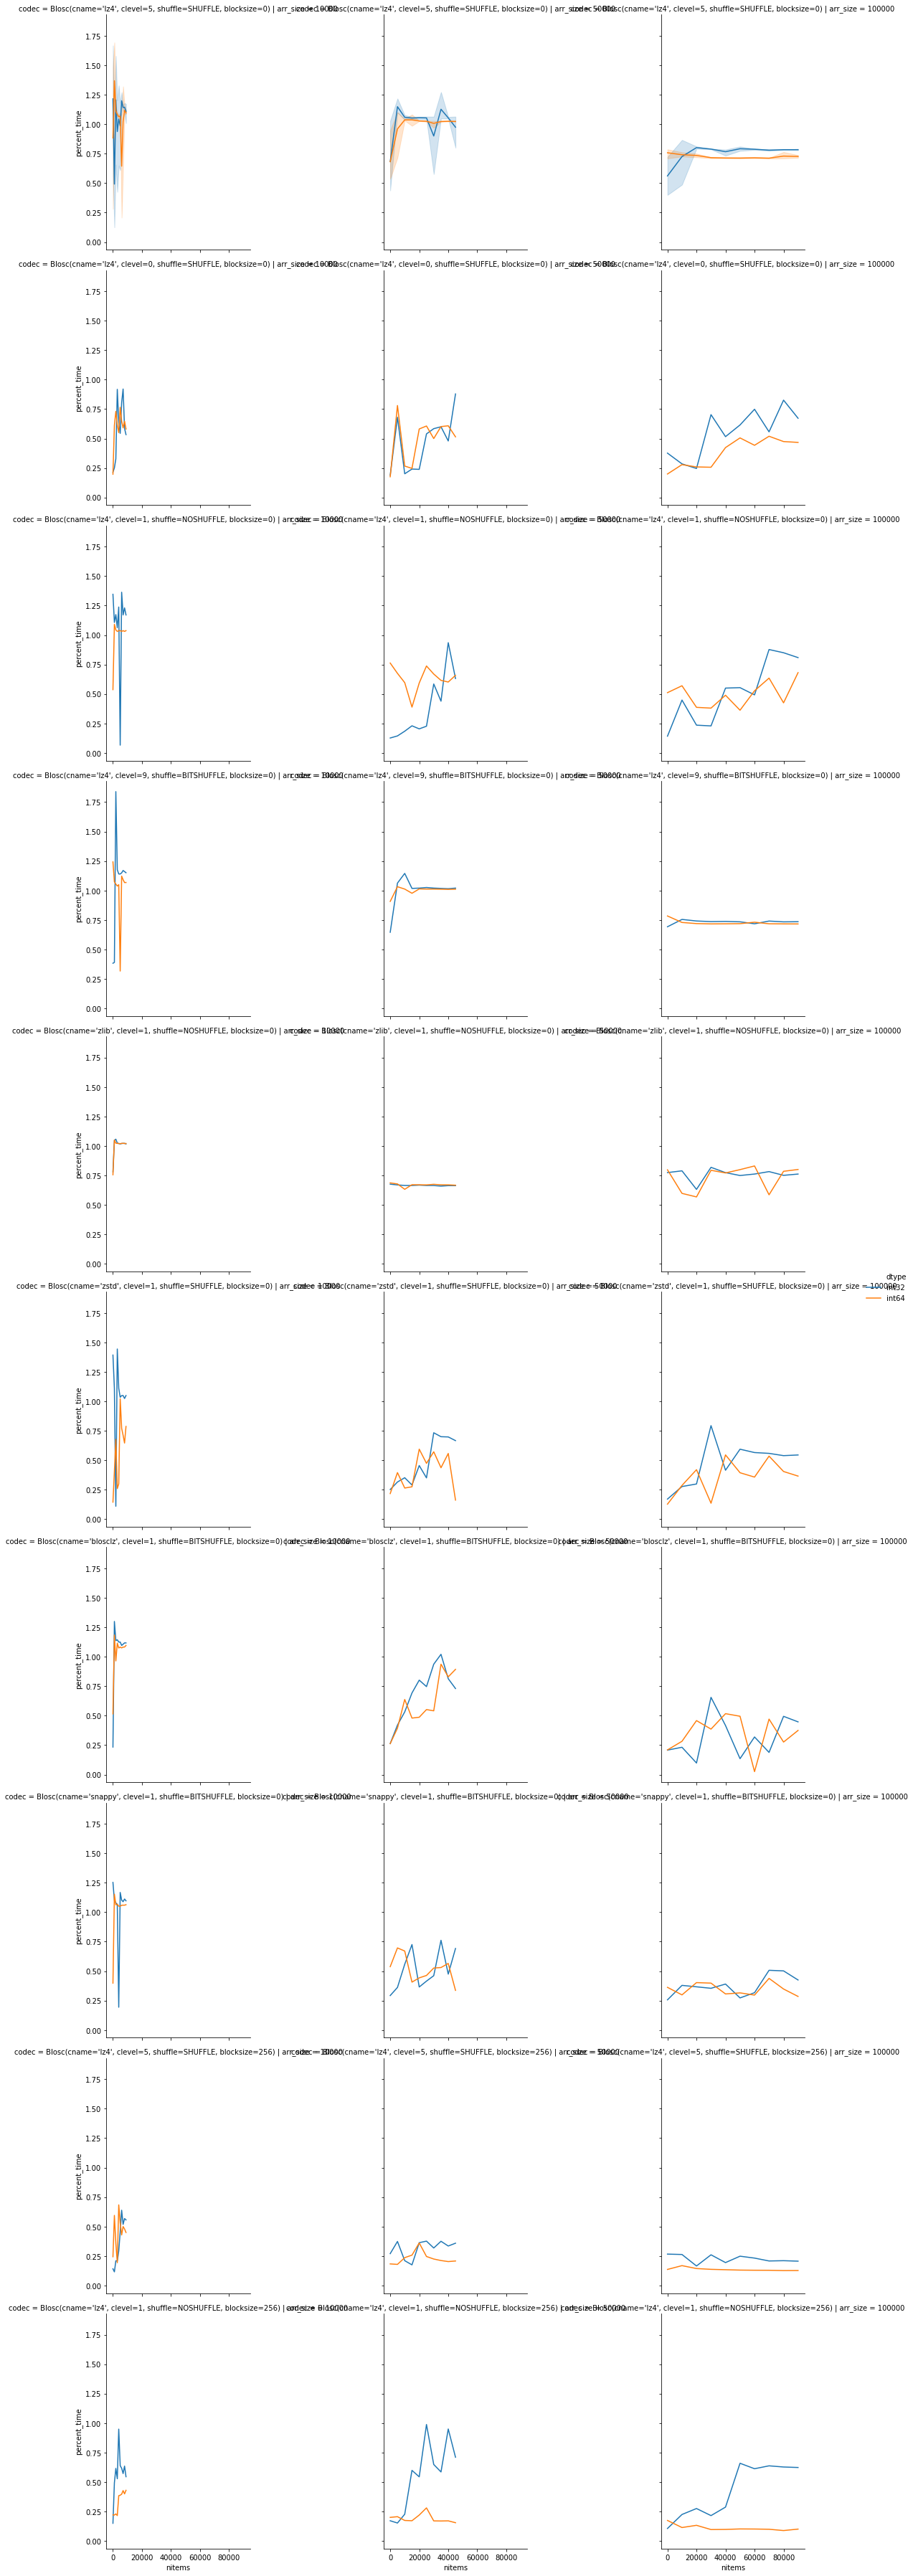

In [247]:
sns.relplot(x='nitems', y='percent_time', hue='dtype', row="codec", col="arr_size", data=df, kind="line")